<a href="https://colab.research.google.com/github/ccorbett0116/Fall2025ResearchProject/blob/main/Research_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Title:
# Authors: Jose Henriquez, Cole Corbett
## Description:
The deployment of medical AI systems across different hospitals raises critical questions about whether fairness and representation quality can be reliably transferred across clinical domains. Models trained on one hospital’s imaging data are often reused in new environments where patient demographics, imaging devices, and diagnostic practices differ substantially, potentially resulting in unintended bias against certain groups. This project investigates this challenge by studying fairness-aware representation alignment in medical imaging. The student will train contrastive learning models—such as SimCLR—independently on two large-scale chest X-ray datasets: CheXpert (from Stanford Hospital) and MIMIC-CXR (from Beth Israel Deaconess Medical Center). After learning embeddings in each domain, the student will apply domain alignment techniques such as Procrustes alignment to map representations from the CheXpert embedding space into the MIMIC-CXR space. The aligned embeddings will then be evaluated using fairness metrics designed for representation spaces, including demographic subgroup alignment, intra- vs. inter-group embedding disparity, and cluster-level demographic parity. The expected outcome is a rigorous understanding of whether fairness properties learned in one hospital setting preserve, degrade, or improve when transferred to another, revealing how robust model fairness is to realworld clinical domain shifts. A practical use case involves a healthcare network seeking to deploy a model trained at a major academic hospital (e.g., Stanford) into a community hospital setting: this project helps determine whether the transferred representations remain equitable across patient groups such as older adults, women, or specific disease cohorts. The findings will support responsible AI deployment in healthcare by highlighting the conditions under which fairness is stable across institutions and identifying scenarios where domain-specific mitigation strategies may be required.

In [16]:
#Process is probably different on colab, this is hyperspecific to me because I'm working on Pycharm connected to my WSL
import sys
import os
!{sys.executable} -m pip install kagglehub polars numpy
#We're going to use polars because it's significantly faster, it's build on rust and enables multi-threaded processing as well as some memory optimizations over pandas.

# Install PyTorch with CUDA 13.0 support (LINUX Link (May work for windows??))
!{sys.executable} -m pip install torch torchvision --index-url https://download.pytorch.org/whl/cu130

# Install PyTorch Lightning and Lightning Bolts for SimCLR
!{sys.executable} -m pip install pytorch-lightning lightning-bolts

# Install sklearn and matplotlib for analysis
!{sys.executable} -m pip install scikit-learn matplotlib

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /home/coding/.virtualenvs/Fall2025ResearchProject/bin/python -m pip install --upgrade pip
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Looking in indexes: https://download.pytorch.org/whl/cu130

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /home/coding/.virtualenvs/Fall2025ResearchProject/bin/python -m pip install --upgrade pip
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /home/coding/.virtualenvs/Fall2025ResearchProject/bin/python -m pip install --upgrade pip
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
  Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using ca

In [63]:
# Imports
import random
import numpy as np
from PIL import Image
import kagglehub
import polars as pol
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, silhouette_score, f1_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier


In [18]:
# Hyperparameters



base_model="resnet50"
max_epochs = 20
max_epochs_mimic = 40
proj_dim = 128 # How many dimensions to project the image into
base_lr = 1e-3
temperature = 0.5
batch_size = 128

num_workers = 12 # This one just effects cpu utilization/training time


In [19]:
# Download datasets

path_chexpert = kagglehub.dataset_download("mimsadiislam/chexpert")
print("Path to chexpert dataset files:", path_chexpert)

path_mimic = kagglehub.dataset_download("itsanmol124/mimic-cxr")
print("Path to mimic dataset files:", path_mimic)

Path to chexpert dataset files: /home/coding/.cache/kagglehub/datasets/mimsadiislam/chexpert/versions/1
Path to mimic dataset files: /home/coding/.cache/kagglehub/datasets/itsanmol124/mimic-cxr/versions/1


In [20]:
dir_chexpert = os.path.join(path_chexpert, "CheXpert-v1.0-small")
dir_mimic = path_mimic

train_csv_chexpert = os.path.join(dir_chexpert, "train.csv")
valid_csv_chexpert = os.path.join(dir_chexpert, "valid.csv")
full_csv_mimic = os.path.join(dir_mimic, "mimic-cxr.csv")

df_complete_mimic = pol.read_csv(full_csv_mimic)
df_train_chexpert = pol.read_csv(train_csv_chexpert)
df_valid_chexpert = pol.read_csv(valid_csv_chexpert)

df_train_mimic = df_complete_mimic.filter(pol.col("split") == "train")
df_valid_mimic = df_complete_mimic.filter(pol.col("split") == "valid")

In [21]:
df_train_mimic.head()

filename,split,label,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Lung Lesion,Lung Opacity,Normal,Pleural Effusion,Pneumonia,Pneumothorax
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""s50000014.jpg""","""train""","""Normal""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"""s50000052.jpg""","""train""","""Normal""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"""s50000125.jpg""","""train""","""Normal""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"""s50000173.jpg""","""train""","""Normal""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"""s50000198.jpg""","""train""","""Consolidation""",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("No GPU available, using CPU")
    device = torch.device("cpu")
print(f"Using device: {device}")

PyTorch version: 2.9.1+cu130
CUDA available: True
CUDA version: 13.0
Number of GPUs: 1
Current GPU: NVIDIA GeForce RTX 5080
Using device: cuda


In [23]:
print(dir_mimic+"/train")

/home/coding/.cache/kagglehub/datasets/itsanmol124/mimic-cxr/versions/1/train


In [24]:
# Use Tensor Cores efficiently on 5080
torch.set_float32_matmul_precision("high")

import ast

# -----------------------
# SimCLR augmentations
# -----------------------
simclr_transform = T.Compose([
    T.Resize(256),
    T.RandomResizedCrop(224, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply(
        [T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)],
        p=0.8,
    ),
    T.RandomGrayscale(p=0.2),
    T.ToTensor(),
    # CXRs are essentially grayscale; simple normalization is fine as a start
    T.Normalize(mean=[0.5], std=[0.5]),
])


# -----------------------
# Single-dataset SimCLR Dataset
# -----------------------
class SimCLRDataset(Dataset):
    """
    Unlabeled dataset for SimCLR: returns (view1, view2) per image.
    This handles ONE dataset (CheXpert OR MIMIC).
    """
    def __init__(self, df, root, path_col, transform=None, is_mimic=False):
        self.transform = transform
        self.is_mimic = is_mimic
        
        # df is a Polars DataFrame; df[path_col] is a Series → .to_list()
        rel_paths = df[path_col].to_list()
        
        # Parse MIMIC paths if needed (they're stored as string lists)
        if is_mimic:
            parsed_paths = []
            for p in rel_paths:
                # Parse string representation of list: "['files/p16/...']" -> 'files/p16/...'
                if isinstance(p, str) and p.startswith('['):
                    try:
                        path_list = ast.literal_eval(p)
                        if path_list and len(path_list) > 0:
                            parsed_paths.append(path_list[0])  # Take first element
                    except:
                        print(f"Warning: Could not parse path: {p}")
                else:
                    parsed_paths.append(p)
            rel_paths = parsed_paths
        
        self.paths = [os.path.join(root, p) for p in rel_paths]

        print(f"Total images for this SimCLR dataset: {len(self.paths)}")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform is None:
            raise ValueError("SimCLRDataset requires a transform.")

        xi = self.transform(img)
        xj = self.transform(img)
        return xi, xj


# -----------------------
# Build DataLoaders
# -----------------------

simclr_train_chexpert = SimCLRDataset(
    df=df_train_chexpert,
    root=path_chexpert,
    path_col="Path",      # CheXpert image path column
    transform=simclr_transform,
    is_mimic=False,
)

simclr_train_loader_chexpert = DataLoader(
    simclr_train_chexpert,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

simclr_train_mimic = SimCLRDataset(
    df=df_train_mimic,
    root=dir_mimic,
    path_col="filename",     # MIMIC image path column
    transform=simclr_transform,
    is_mimic=True,        # Enable MIMIC path parsing
)

simclr_train_loader_mimic = DataLoader(
    simclr_train_mimic,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

Total images for this SimCLR dataset: 223414
Total images for this SimCLR dataset: 83837


In [25]:
# Use Tensor Cores efficiently on 5080
torch.set_float32_matmul_precision("high")

# -----------------------
# SimCLR augmentations
# -----------------------
simclr_transform = T.Compose([
    T.Resize(256),
    T.RandomResizedCrop(224, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply(
        [T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)],
        p=0.8,
    ),
    T.RandomGrayscale(p=0.2),
    T.ToTensor(),
    # CXRs are essentially grayscale; simple normalization is fine as a start
    T.Normalize(mean=[0.5], std=[0.5]),
])


# -----------------------
# Single-dataset SimCLR Dataset
# -----------------------
class SimCLRDataset(Dataset):
    """
    Unlabeled dataset for SimCLR: returns (view1, view2) per image.
    This handles ONE dataset (CheXpert OR MIMIC).
    """
    def __init__(self, df, root, path_col, transform=None):
        self.transform = transform
        self.root = root
        
        # df is a Polars DataFrame; df[path_col] is a Series → .to_list()
        rel_paths = df[path_col].to_list()
        self.paths = [os.path.join(root, p) for p in rel_paths]

        print(f"Total images for this SimCLR dataset: {len(self.paths)}")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform is None:
            raise ValueError("SimCLRDataset requires a transform.")

        xi = self.transform(img)
        xj = self.transform(img)
        return xi, xj


# -----------------------
# Build DataLoaders
# -----------------------

# CheXpert
simclr_train_chexpert = SimCLRDataset(
    df=df_train_chexpert,
    root=path_chexpert,      # CheXpert paths include the subdirectory
    path_col="Path",
    transform=simclr_transform,
)

simclr_train_loader_chexpert = DataLoader(
    simclr_train_chexpert,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

# MIMIC Train
simclr_train_mimic = SimCLRDataset(
    df=df_train_mimic,
    root=path_mimic+"/train",    # Images are in train/ directory
    path_col="filename",     # MIMIC uses 'filename' column
    transform=simclr_transform,
)

simclr_train_loader_mimic = DataLoader(
    simclr_train_mimic,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

Total images for this SimCLR dataset: 223414
Total images for this SimCLR dataset: 83837


In [26]:
class SimCLR(pl.LightningModule):
    def __init__(
        self,
        base_model: str = "resnet34",
        out_dim: int = 128,
        lr: float = 1e-3,
        temperature: float = 0.5,
    ):
        super().__init__()
        self.save_hyperparameters()

        # -------- Encoder (backbone) --------
        if base_model == "resnet34":
            backbone = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        elif base_model == "resnet50":
            backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        else:
            raise ValueError(f"Unsupported base_model: {base_model}")

        feat_dim = backbone.fc.in_features
        backbone.fc = nn.Identity()
        self.encoder = backbone

        # -------- Projection head --------
        self.projector = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.ReLU(inplace=True),
            nn.Linear(feat_dim, out_dim),
        )

        self.temperature = temperature
        self.lr = lr

    def forward(self, x):
        h = self.encoder(x)           # [B, feat_dim]
        z = self.projector(h)         # [B, out_dim]
        z = F.normalize(z, dim=1)     # L2-normalize
        return z

    def nt_xent_loss(self, z_i, z_j):
        """
        NT-Xent (InfoNCE) loss used in SimCLR.
        z_i, z_j: [B, D] normalized embeddings for the two views
        """
        batch_size = z_i.size(0)
        z = torch.cat([z_i, z_j], dim=0)   # [2B, D]

        # Cosine similarity matrix: [2B, 2B]
        sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)
        sim = sim / self.temperature

        # Mask out self-similarity on diagonal
        self_mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
        sim = sim.masked_fill(self_mask, float("-inf"))

        # Positive for each i is i+batch_size (wrap around)
        pos_indices = torch.arange(2 * batch_size, device=z.device)
        pos_indices = (pos_indices + batch_size) % (2 * batch_size)

        loss = F.cross_entropy(sim, pos_indices)
        return loss

    def training_step(self, batch, batch_idx):
        x_i, x_j = batch
        z_i = self(x_i)
        z_j = self(x_j)
        loss = self.nt_xent_loss(z_i, z_j)
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.trainer.max_epochs
        )
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

In [27]:
lr_monitor = LearningRateMonitor(logging_interval="epoch")

# -----------------------
# Loggers
# -----------------------

tb_logger_chexpert = TensorBoardLogger(
    save_dir="tb_logs",
    name="simclr_chexpert"
)

tb_logger_mimic = TensorBoardLogger(
    save_dir="tb_logs",
    name="simclr_mimic"
)

# -----------------------
# CheXpert SimCLR
# -----------------------
simclr_chexpert = SimCLR(
    base_model=base_model,
    out_dim=proj_dim,
    lr=base_lr,
    temperature=temperature,
)

ckpt_chexpert = ModelCheckpoint(
    dirpath="checkpoints/simclr_chexpert",
    filename="simclr-chexpert-{epoch:02d}-{train_loss:.4f}",
    save_top_k=3,
    monitor="train_loss",
    mode="min",
    save_last=True,
)

trainer_chexpert = pl.Trainer(
    max_epochs=max_epochs,
    accelerator="gpu" if torch.cuda.is_available() else "auto",
    devices=1,
    precision="bf16" if torch.cuda.is_available() else "32",
    callbacks=[ckpt_chexpert, lr_monitor],
    logger=tb_logger_chexpert,
    log_every_n_steps=50,
)


# -----------------------
# MIMIC SimCLR
# -----------------------
simclr_mimic = SimCLR(
    base_model=base_model,
    out_dim=proj_dim,
    lr=base_lr,
    temperature=temperature,
)

ckpt_mimic = ModelCheckpoint(
    dirpath="checkpoints/simclr_mimic",
    filename="simclr-mimic-{epoch:02d}-{train_loss:.4f}",
    save_top_k=3,
    monitor="train_loss",
    mode="min",
    save_last=True,
)

trainer_mimic = pl.Trainer(
    max_epochs=max_epochs_mimic,
    accelerator="gpu" if torch.cuda.is_available() else "auto",
    devices=1,
    precision="bf16" if torch.cuda.is_available() else "32",
    callbacks=[ckpt_mimic, lr_monitor],
    logger=tb_logger_mimic,
    log_every_n_steps=50,
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
# print("=== Training SimCLR on CheXpert ===")
# trainer_chexpert.fit(simclr_chexpert, simclr_train_loader_chexpert)

In [ ]:
print("=== Training SimCLR on MIMIC ===")
trainer_mimic.fit(simclr_mimic, simclr_train_loader_mimic)

In [ ]:
# Load trained SimCLR models
simclr_chexpert = SimCLR.load_from_checkpoint("./checkpoints/simclr_chexpert/last.ckpt")
simclr_mimic = SimCLR.load_from_checkpoint("./checkpoints/simclr_mimic/last.ckpt")

simclr_chexpert.eval().cuda()
simclr_mimic.eval().cuda()


In [ ]:
# ===============================
# Validation Transform (NO AUGS)
# ===============================
val_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
])


# ===============================
# Validation Datasets
# ===============================
chexpert_val_ds = SimCLRDataset(
    df=df_valid_chexpert,
    root=path_chexpert,
    path_col="Path",
    transform=val_transform,
)

mimic_val_ds = SimCLRDataset(
    df=df_valid_mimic,
    root=path_mimic + "/valid",
    path_col="filename",
    transform=val_transform,
)


# ===============================
# Validation DataLoaders
# ===============================
chexpert_val_loader = DataLoader(
    chexpert_val_ds,
    batch_size=64,
    shuffle=False,
    num_workers=0,
)

mimic_val_loader = DataLoader(
    mimic_val_ds,
    batch_size=64,
    shuffle=False,
    num_workers=0,
)


# ===============================
# Embedding Extraction Function
# ===============================
def extract_embeddings(model, loader):
    model.eval()
    
    model = model.to("cuda" if torch.cuda.is_available() else "cpu")

    all_embeds = []
    with torch.no_grad():
        for (x_i, _) in loader:  # only need one view
            x_i = x_i.to(model.device)
            z = model(x_i)
            all_embeds.append(z.cpu())

    return torch.cat(all_embeds, dim=0)


# ===============================
# Extract Embeddings
# ===============================
emb_chexpert = extract_embeddings(simclr_chexpert, chexpert_val_loader)
emb_mimic   = extract_embeddings(simclr_mimic, mimic_val_loader)

print("CheXpert embeddings:", emb_chexpert.shape)
print("MIMIC embeddings:", emb_mimic.shape)


Total images for this SimCLR dataset: 234
Total images for this SimCLR dataset: 711
cuda:<function is_available at 0x0000022804B68040>
cuda:<function is_available at 0x0000022804B68040>
CheXpert embeddings: torch.Size([234, 128])
MIMIC embeddings: torch.Size([711, 128])


In [24]:
torch.save(emb_chexpert, "emb_chexpert.pt")
torch.save(emb_mimic, "emb_mimic.pt")


### Evaluation of Embeddings

We visualize and quantitatively evaluate the learned SimCLR embeddings to understand how well the model captures meaningful structure in the data.

**t-SNE (t-distributed Stochastic Neighbor Embedding):**  
t-SNE is a nonlinear dimensionality reduction technique that maps high-dimensional embeddings (e.g., 128-D SimCLR vectors) into 2D or 3D space while preserving local neighborhoods. This allows us to visually inspect whether images with similar features or labels cluster together in embedding space.

**Silhouette Score:**  
The silhouette score quantifies cluster quality. For each point \(i\), it is defined as:  
s(i) = (b(i) - a(i)) / max(a(i), b(i))
where \(a(i)\) is the average intra-cluster distance and \(b(i)\) is the average nearest-cluster distance. Scores close to 1 indicate tight, well-separated clusters; scores near 0 or negative indicate overlapping or poorly formed clusters.

**K-Nearest Neighbors (KNN) Accuracy:**  
KNN on the embeddings provides a downstream quantitative measure of representation quality. By predicting labels using the nearest neighbors in embedding space, we assess whether the learned embeddings preserve semantic similarity. Higher accuracy indicates that images with similar labels are close together in embedding space, reflecting the model's ability to learn discriminative and meaningful features.


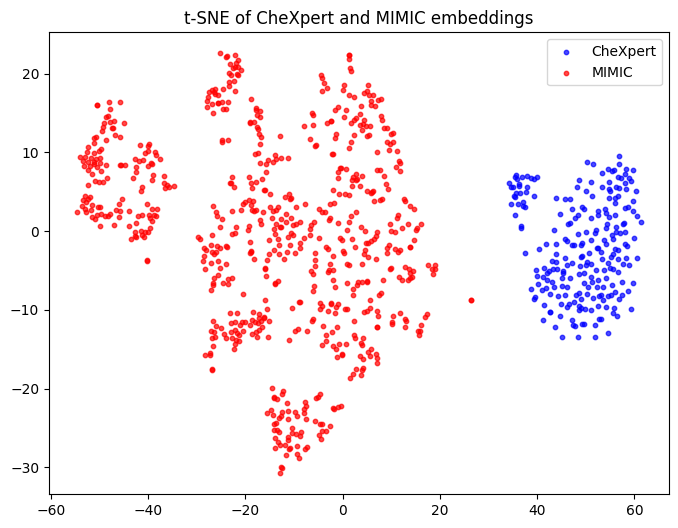

In [ ]:



# Combine embeddings
all_emb = torch.cat([emb_chexpert, emb_mimic], dim=0).cpu().numpy()

# Create labels for coloring: 0 = CheXpert, 1 = MIMIC
labels = np.array([0]*emb_chexpert.shape[0] + [1]*emb_mimic.shape[0])

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(all_emb)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(emb_2d[labels==0, 0], emb_2d[labels==0, 1], s=10, alpha=0.7, label="CheXpert", color="blue")
plt.scatter(emb_2d[labels==1, 0], emb_2d[labels==1, 1], s=10, alpha=0.7, label="MIMIC", color="red")
plt.title("t-SNE of CheXpert and MIMIC embeddings")
plt.legend()
plt.show()


In [41]:
print("CheXpert columns:", df_valid_chexpert.columns)
print("MIMIC columns:", df_valid_mimic.columns)


CheXpert columns: ['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
MIMIC columns: ['filename', 'split', 'label', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Lung Lesion', 'Lung Opacity', 'Normal', 'Pleural Effusion', 'Pneumonia', 'Pneumothorax']


In [42]:
# CheXpert validation labels
chexpert_label_cols = [
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
    'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation',
    'Pneumonia', 'Atelectasis', 'Pneumothorax',
    'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices'
]
chexpert_val_labels = df_valid_chexpert.select(chexpert_label_cols).to_numpy()

# MIMIC validation labels
mimic_label_cols = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
    'Enlarged Cardiomediastinum', 'Lung Lesion', 'Lung Opacity',
    'Normal', 'Pleural Effusion', 'Pneumonia', 'Pneumothorax'
]
mimic_val_labels = df_valid_mimic.select(mimic_label_cols).to_numpy()


To quantitatively evaluate our embeddings, we start with the Silhouette Score. This measures how well each data point (here, each X-ray embedding) fits within its assigned class (disease label) compared to other classes. A higher score means the embeddings form more distinct clusters, which indicates that our SimCLR model is capturing meaningful patterns in the images.

In [ ]:



# Only consider the disease labels as clusters (ignore 'No Finding' if desired)
# Convert multi-label to single-label by taking argmax for simplicity
chexpert_val_single_label = np.argmax(chexpert_val_labels, axis=1)

# Compute silhouette score
sil_score_chexpert = silhouette_score(emb_chexpert.numpy(), chexpert_val_single_label)
print(f"Silhouette Score (CheXpert embeddings): {sil_score_chexpert:.4f}")


Silhouette Score (CheXpert embeddings): -0.0116


In [ ]:



# Only consider the disease labels as clusters (ignore 'No Finding' if desired)
# Convert multi-label to single-label by taking argmax for simplicity
MIMIC_val_single_label = np.argmax(mimic_val_labels, axis=1)

# Compute silhouette score
sil_score_MIMIC = silhouette_score(emb_mimic.numpy(), MIMIC_val_single_label)
print(f"Silhouette Score (MIMIC embeddings): {sil_score_MIMIC:.4f}")


Silhouette Score (MIMIC embeddings): -0.0381


To quantitatively evaluate the quality of our SimCLR embeddings, we can use a K-Nearest Neighbor (KNN) classifier.
The idea is simple: if the embeddings are meaningful, images with the same label should be closer together in embedding space, so a KNN should classify them reasonably well.
This gives a practical, label-based measure of how well the self-supervised embeddings capture relevant structure in the data.

In [45]:
# Use a simple KNN on embeddings
def knn_eval(embeddings, labels, k=5):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(embeddings, labels)
    preds = knn.predict(embeddings)
    acc = accuracy_score(labels, preds)
    return acc

# CheXpert
chexpert_labels = df_valid_chexpert.select([
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices'
]).to_numpy()

# Convert one-hot / multi-label to single class for simplicity (e.g., argmax)
chexpert_labels_class = chexpert_labels.argmax(axis=1)

chexpert_knn_acc = knn_eval(emb_chexpert.numpy(), chexpert_labels_class)
print("CheXpert KNN accuracy on embeddings:", chexpert_knn_acc)

# MIMIC
mimic_labels = df_valid_mimic.select([
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
    'Enlarged Cardiomediastinum', 'Lung Lesion', 'Lung Opacity', 'Normal',
    'Pleural Effusion', 'Pneumonia', 'Pneumothorax'
]).to_numpy()
mimic_labels_class = mimic_labels.argmax(axis=1)

mimic_knn_acc = knn_eval(emb_mimic.numpy(), mimic_labels_class)
print("MIMIC KNN accuracy on embeddings:", mimic_knn_acc)

CheXpert KNN accuracy on embeddings: 0.7222222222222222
MIMIC KNN accuracy on embeddings: 0.509142053445851


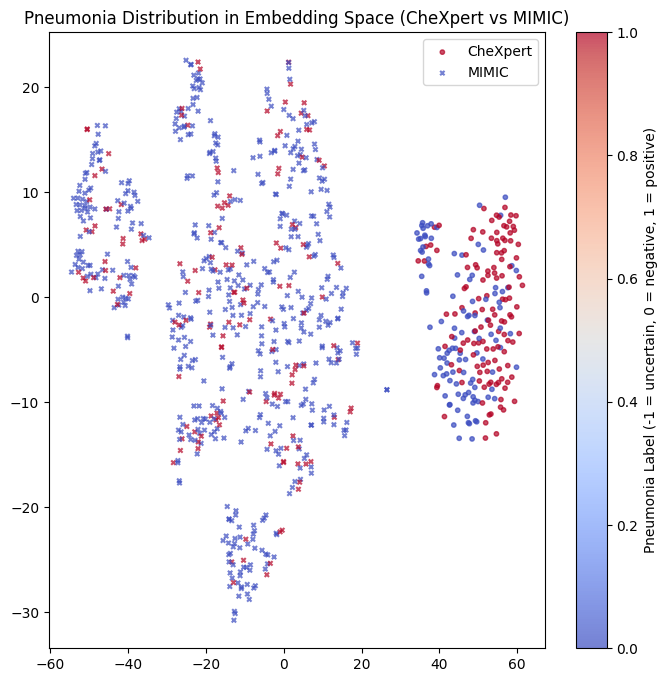

In [52]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# ---- 1. Extract Pneumonia labels for both datasets ----
labels_chex = df_valid_chexpert["Lung Opacity"].fill_null(-1).to_numpy()
labels_mimic = df_valid_mimic["Lung Opacity"].fill_null(-1).to_numpy()

emb_chex_np = emb_chexpert.cpu().numpy()
emb_mimic_np = emb_mimic.cpu().numpy()

# ---- 2. Combine embeddings for joint t-SNE projection ----
emb_combined = np.vstack([emb_chex_np, emb_mimic_np])

# Create dataset ID array to distinguish colors:
dataset_id = np.array([0]*len(emb_chex_np) + [1]*len(emb_mimic_np))

# ---- 3. Run t-SNE on the combined dataset ----
tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(emb_combined)

# Split back the projected points
chex_points = emb_2d[:len(emb_chex_np)]
mimic_points = emb_2d[len(emb_chex_np):]

# ---- 4. Plot (side-by-side comparison on SAME 2D space) ----
plt.figure(figsize=(8,8))

plt.scatter(
    chex_points[:,0], chex_points[:,1],
    c=labels_chex,
    cmap="coolwarm",
    s=10,
    alpha=0.7,
    label="CheXpert"
)

plt.scatter(
    mimic_points[:,0], mimic_points[:,1],
    c=labels_mimic,
    cmap="coolwarm",
    s=10,
    alpha=0.7,
    marker='x',
    label="MIMIC"
)

plt.title("Pneumonia Distribution in Embedding Space (CheXpert vs MIMIC)")
plt.colorbar(label="Pneumonia Label (-1 = uncertain, 0 = negative, 1 = positive)")
plt.legend()
plt.show()


CheXpert pneumonia cases: 126
MIMIC pneumonia cases: 148


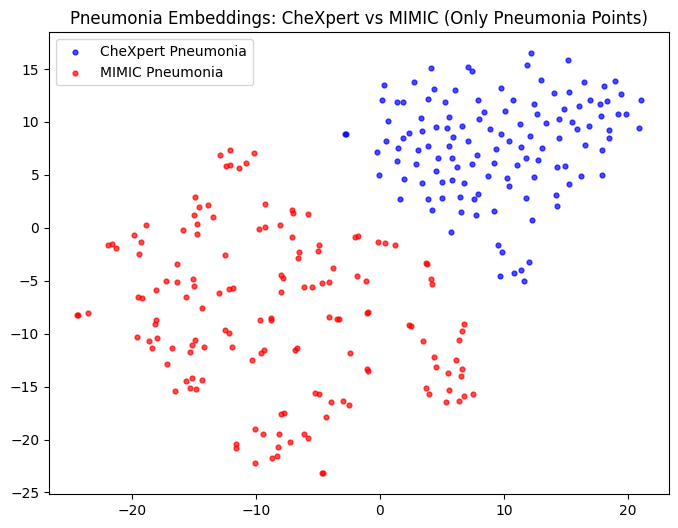

In [51]:


# -------------------------
# 1. Get pneumonia labels
# -------------------------
labels_chex = df_valid_chexpert["Lung Opacity"].fill_null(-1).to_numpy()
labels_mimic = df_valid_mimic["Lung Opacity"].fill_null(-1).to_numpy()

emb_chex_np = emb_chexpert.cpu().numpy()
emb_mimic_np = emb_mimic.cpu().numpy()

# -------------------------
# 2. Filter to pneumonia only
# -------------------------
chex_mask = labels_chex == 1
mimic_mask = labels_mimic == 1

chex_pneu_emb = emb_chex_np[chex_mask]
mimic_pneu_emb = emb_mimic_np[mimic_mask]

print("CheXpert pneumonia cases:", chex_pneu_emb.shape[0])
print("MIMIC pneumonia cases:", mimic_pneu_emb.shape[0])

# -------------------------
# 3. Combine embeddings for t-SNE
# -------------------------
combined = np.vstack([chex_pneu_emb, mimic_pneu_emb])

tsne = TSNE(n_components=2, random_state=42)
combined_2d = tsne.fit_transform(combined)

n_chex = chex_pneu_emb.shape[0]

chex_2d = combined_2d[:n_chex]
mimic_2d = combined_2d[n_chex:]

# -------------------------
# 4. Plot (only pneumonia points)
# -------------------------
plt.figure(figsize=(8, 6))

plt.scatter(
    chex_2d[:, 0], chex_2d[:, 1],
    s=12, alpha=0.7, label="CheXpert Pneumonia", color="blue"
)

plt.scatter(
    mimic_2d[:, 0], mimic_2d[:, 1],
    s=12, alpha=0.7, label="MIMIC Pneumonia", color="red"
)

plt.title("Pneumonia Embeddings: CheXpert vs MIMIC (Only Pneumonia Points)")
plt.legend()
plt.show()


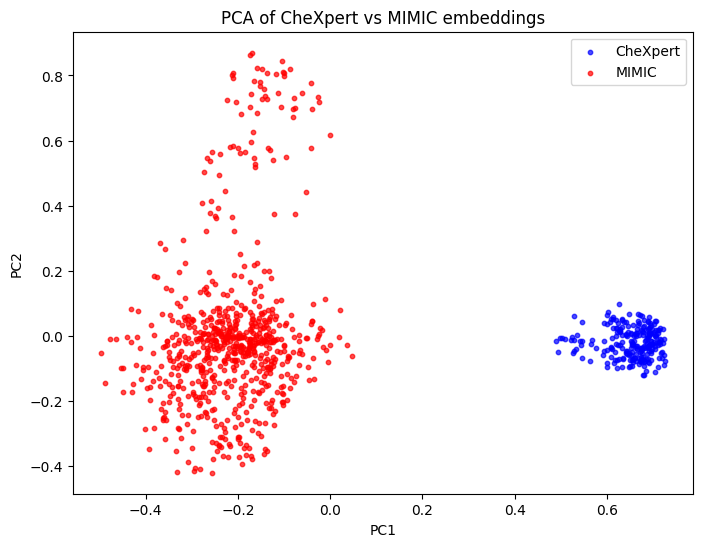

Variance explained by PC1 and PC2: 0.155, 0.050


In [54]:
# Convert embeddings to numpy
emb_chex_np = emb_chexpert.cpu().numpy()
emb_mimic_np = emb_mimic.cpu().numpy()

# Combine embeddings to fit PCA together
all_emb = np.concatenate([emb_chex_np, emb_mimic_np], axis=0)

# Fit PCA to reduce to 2 components
pca = PCA(n_components=2, random_state=42)
all_emb_2d = pca.fit_transform(all_emb)

# Split transformed embeddings back
chex_2d = all_emb_2d[:len(emb_chex_np)]
mimic_2d = all_emb_2d[len(emb_chex_np):]

# Plot
plt.figure(figsize=(8,6))
plt.scatter(chex_2d[:,0], chex_2d[:,1], s=10, alpha=0.7, label="CheXpert", color="blue")
plt.scatter(mimic_2d[:,0], mimic_2d[:,1], s=10, alpha=0.7, label="MIMIC", color="red")
plt.title("PCA of CheXpert vs MIMIC embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# Optional: variance explained
explained = pca.explained_variance_ratio_
print(f"Variance explained by PC1 and PC2: {explained[0]:.3f}, {explained[1]:.3f}")

# PCA of CheXpert & MIMIC Embeddings

**What this test does:**  
- PCA reduces high-dimensional embeddings (128D) to 2D for visualization.  
- Each point represents a single chest X-ray image, projected into a plane capturing the main variance in the data.  
- Coloring by Pneumonia label lets us see whether images with the disease cluster together, and if the clusters differ between datasets.

**Why it’s relevant:**  
- By comparing CheXpert and MIMIC in the **same embedding space**, we can evaluate **dataset similarity and domain shifts**.  
- If pneumonia cases cluster together across both datasets, it indicates the model has learned disease-relevant features that generalize.  
- Differences in cluster tightness or overlap may suggest **dataset-specific biases** or **labeling inconsistencies**, which are critical for downstream model performance.

**Insights we can gain:**  
- How well the SimCLR embeddings separate diseased vs healthy cases.  
- Differences in disease representation across CheXpert and MIMIC.  
- Whether embeddings are suitable for cross-dataset tasks like transfer learning.


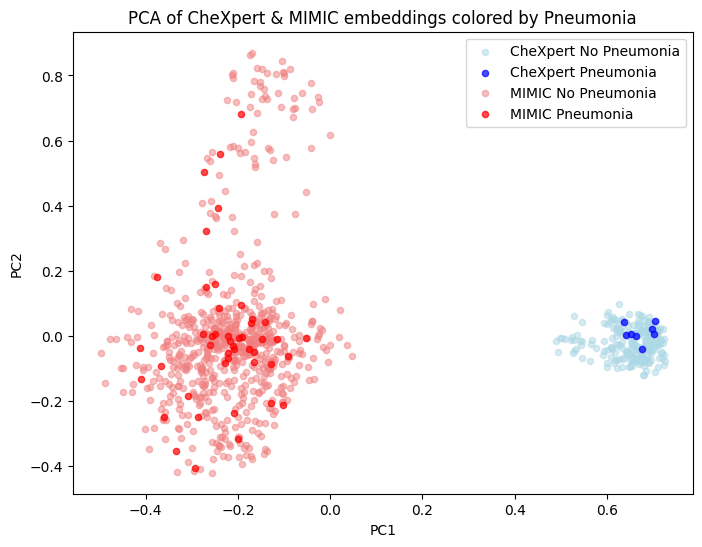

In [58]:

# -------------------------
# 1. Extract labels for Pneumonia (Polars)
# -------------------------
labels_chex = df_valid_chexpert.select("Pneumonia").to_numpy().flatten()
labels_mimic = df_valid_mimic.select("Pneumonia").to_numpy().flatten()

# Filter out missing labels (-1)
chex_mask = labels_chex != -1
mimic_mask = labels_mimic != -1

emb_chex_np = emb_chexpert.cpu().numpy()[chex_mask]
emb_mimic_np = emb_mimic.cpu().numpy()[mimic_mask]

labels_chex = labels_chex[chex_mask]
labels_mimic = labels_mimic[mimic_mask]

# -------------------------
# 2. Combine embeddings and run PCA
# -------------------------
combined_emb = np.vstack([emb_chex_np, emb_mimic_np])
pca = PCA(n_components=2, random_state=42)
pca_emb = pca.fit_transform(combined_emb)

# Split back for plotting
pca_chex = pca_emb[:len(emb_chex_np)]
pca_mimic = pca_emb[len(emb_chex_np):]

# -------------------------
# 3. Plot PCA colored by Pneumonia
# -------------------------
plt.figure(figsize=(8, 6))

# CheXpert
plt.scatter(
    pca_chex[labels_chex==0, 0], pca_chex[labels_chex==0, 1],
    color='lightblue', label='CheXpert No Pneumonia', alpha=0.5, s=20
)
plt.scatter(
    pca_chex[labels_chex==1, 0], pca_chex[labels_chex==1, 1],
    color='blue', label='CheXpert Pneumonia', alpha=0.7, s=20
)

# MIMIC
plt.scatter(
    pca_mimic[labels_mimic==0, 0], pca_mimic[labels_mimic==0, 1],
    color='lightcoral', label='MIMIC No Pneumonia', alpha=0.5, s=20
)
plt.scatter(
    pca_mimic[labels_mimic==1, 0], pca_mimic[labels_mimic==1, 1],
    color='red', label='MIMIC Pneumonia', alpha=0.7, s=20
)

plt.title("PCA of CheXpert & MIMIC embeddings colored by Pneumonia")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


## UMAP Visualization of Chest X-ray Embeddings

UMAP (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique similar to t-SNE but often preserves more of the global structure of the data. By projecting our high-dimensional embeddings (128-dimensional SimCLR features) down to 2D, we can visualize how the model organizes chest X-ray images.

This is relevant because:
- It helps us **see if the embeddings naturally cluster according to disease labels**.
- It allows **cross-dataset comparisons** (CheXpert vs MIMIC) to assess generalization.
- UMAP is faster than t-SNE for larger datasets and can maintain a sense of overall geometry of the data.

We will run UMAP on the embeddings of both CheXpert and MIMIC validation sets and plot them on the same figure for comparison.


Exception ignored in: <function _ConnectionBase.__del__ at 0x000002280568C680>
Traceback (most recent call last):
  File "c:\Users\joseh\.conda\envs\py312\Lib\multiprocessing\connection.py", line 133, in __del__
    self._close()
  File "c:\Users\joseh\.conda\envs\py312\Lib\multiprocessing\connection.py", line 282, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid
Traceback (most recent call last):
  File "c:\Users\joseh\.conda\envs\py312\Lib\multiprocessing\queues.py", line 259, in _feed
    reader_close()
  File "c:\Users\joseh\.conda\envs\py312\Lib\multiprocessing\connection.py", line 178, in close
    self._close()
  File "c:\Users\joseh\.conda\envs\py312\Lib\multiprocessing\connection.py", line 282, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid
Traceback (most recent call last):
  File "c:\Users\joseh\.conda\envs\py312\Lib\multiprocessing\queues.py", line 259, in _feed
    reader_close()
  File "c:\Users\jos

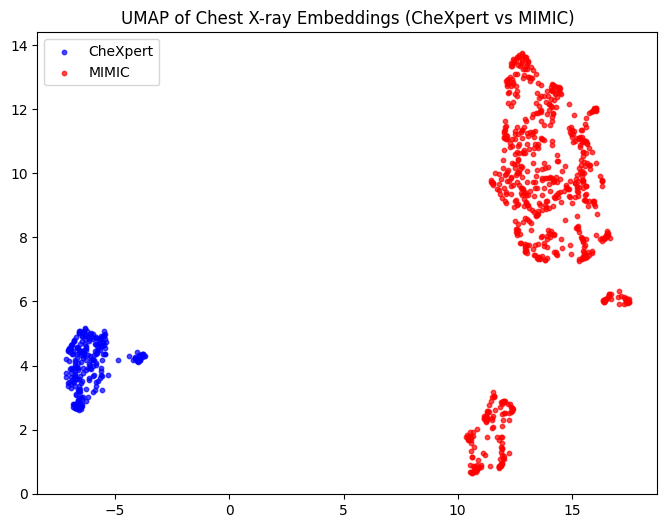

In [59]:
import umap


# ---- 1. Convert embeddings to numpy ----
emb_chex_np = emb_chexpert.cpu().numpy()
emb_mimic_np = emb_mimic.cpu().numpy()

# ---- 2. Fit UMAP on both datasets together for a shared space ----
all_emb = np.vstack([emb_chex_np, emb_mimic_np])
umap_model = umap.UMAP(n_components=2, random_state=42)
emb_2d = umap_model.fit_transform(all_emb)

# ---- 3. Split back to original datasets ----
emb_chex_2d = emb_2d[:len(emb_chex_np)]
emb_mimic_2d = emb_2d[len(emb_chex_np):]

# ---- 4. Plot ----
plt.figure(figsize=(8,6))
plt.scatter(emb_chex_2d[:, 0], emb_chex_2d[:, 1], s=10, alpha=0.7, label='CheXpert', color='blue')
plt.scatter(emb_mimic_2d[:, 0], emb_mimic_2d[:, 1], s=10, alpha=0.7, label='MIMIC', color='red')
plt.title("UMAP of Chest X-ray Embeddings (CheXpert vs MIMIC)")
plt.legend()
plt.show()


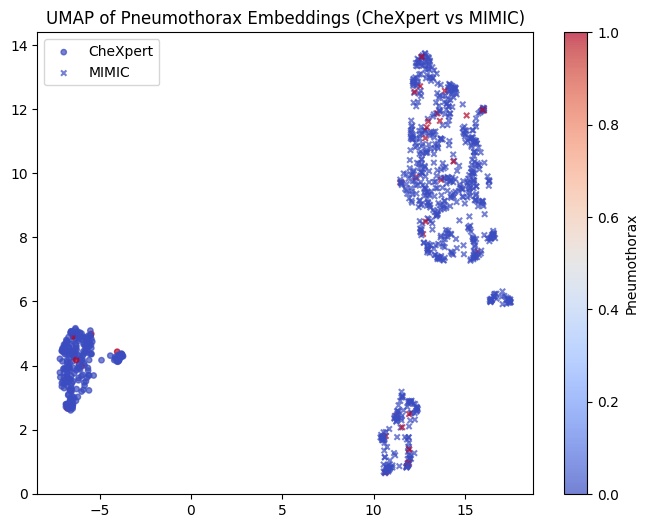

In [ ]:
disease_name = "Pneumothorax"  # Change to other diseases as needed

labels_chex = df_valid_chexpert[disease_name].fill_null(-1).to_numpy()
labels_mimic = df_valid_mimic[disease_name].fill_null(-1).to_numpy()

# ---- 2. Mask non-disease points if desired (-1 is treated as missing) ----
mask_chex = labels_chex != -1
mask_mimic = labels_mimic != -1

# ---- 3. Plot UMAP colored by disease ----
plt.figure(figsize=(8,6))
plt.scatter(
    emb_chex_2d[mask_chex, 0], emb_chex_2d[mask_chex, 1], 
    c=labels_chex[mask_chex], cmap="coolwarm", s=15, alpha=0.7, label="CheXpert"
)
plt.scatter(
    emb_mimic_2d[mask_mimic, 0], emb_mimic_2d[mask_mimic, 1], 
    c=labels_mimic[mask_mimic], cmap="coolwarm", s=15, alpha=0.7, marker='x', label="MIMIC"
)
plt.colorbar(label=disease_name)
plt.title(f"UMAP of {disease_name} Embeddings (CheXpert vs MIMIC)")
plt.legend()
plt.show()

## Cross-Dataset KNN Evaluation

We want to test **how well the features learned by SimCLR on one dataset generalize to another dataset**. 

Steps:
1. Train a simple K-Nearest Neighbors (KNN) classifier using embeddings from CheXpert and their labels.
2. Test the classifier on MIMIC embeddings (and vice versa).
3. Compute accuracy or F1-score.

Interpretation:
- High cross-dataset accuracy → embeddings capture **generalizable clinical features**.
- Low cross-dataset accuracy → embeddings are **dataset-specific**, possibly due to domain differences in image acquisition or labeling.


In [64]:



# ---- 1. Select disease for cross-examination ----
disease_name = "Pneumonia"

# ---- 2. Get labels (Polars to NumPy) ----
labels_chex = df_valid_chexpert[disease_name].fill_null(-1).to_numpy()
labels_mimic = df_valid_mimic[disease_name].fill_null(-1).to_numpy()

# Mask out missing labels
mask_chex = labels_chex != -1
mask_mimic = labels_mimic != -1

X_train = emb_chexpert.cpu().numpy()[mask_chex]
y_train = labels_chex[mask_chex]

X_test = emb_mimic.cpu().numpy()[mask_mimic]
y_test = labels_mimic[mask_mimic]

# ---- 3. Train KNN on CheXpert and test on MIMIC ----
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Cross-Dataset KNN (CheXpert -> MIMIC) Accuracy: {accuracy:.3f}")
print(f"Cross-Dataset KNN (CheXpert -> MIMIC) F1-score: {f1:.3f}")

# ---- Optional: Reverse (MIMIC -> CheXpert) ----
X_train_rev = emb_mimic.cpu().numpy()[mask_mimic]
y_train_rev = labels_mimic[mask_mimic]

X_test_rev = emb_chexpert.cpu().numpy()[mask_chex]
y_test_rev = labels_chex[mask_chex]

knn_rev = KNeighborsClassifier(n_neighbors=5)
knn_rev.fit(X_train_rev, y_train_rev)
y_pred_rev = knn_rev.predict(X_test_rev)

accuracy_rev = accuracy_score(y_test_rev, y_pred_rev)
f1_rev = f1_score(y_test_rev, y_pred_rev)

print(f"Cross-Dataset KNN (MIMIC -> CheXpert) Accuracy: {accuracy_rev:.3f}")
print(f"Cross-Dataset KNN (MIMIC -> CheXpert) F1-score: {f1_rev:.3f}")


Cross-Dataset KNN (CheXpert -> MIMIC) Accuracy: 0.935
Cross-Dataset KNN (CheXpert -> MIMIC) F1-score: 0.000
Cross-Dataset KNN (MIMIC -> CheXpert) Accuracy: 0.966
Cross-Dataset KNN (MIMIC -> CheXpert) F1-score: 0.000


# Cross-Dataset AUROC Evaluation

**Objective:**  
Assess how well embeddings learned from one dataset (CheXpert or MIMIC) generalize to the other using AUROC (Area Under the Receiver Operating Characteristic curve).

**Why AUROC:**  
- Measures the ability to distinguish positive (disease) vs. negative (no disease) cases.  
- Robust to class imbalance, which is common in medical datasets like Pneumonia.  
- Higher AUROC indicates embeddings capture meaningful disease-specific features that transfer across datasets.

**Method:**  
1. Extract embeddings for the validation sets of both datasets.  
2. Train a logistic regression classifier on one dataset’s embeddings and labels.  
3. Test the classifier on the other dataset’s embeddings.  
4. Compute AUROC to quantify how well the learned embeddings generalize.

**Interpretation:**  
- **High AUROC** → Features learned on the source dataset generalize well; disease patterns are captured effectively.  
- **Low AUROC** → Embeddings may be dataset-specific or missing key disease features; indicates areas for further research or improvement.

This analysis helps us evaluate **cross-dataset robustness** of self-supervised embeddings, which is crucial for clinical applications where data distribution varies across hospitals or populations.


In [66]:

# ---- 1. Select disease for cross-examination ----
disease_name = "Pneumonia"

# ---- 2. Get labels (Polars to NumPy) ----
labels_chex = df_valid_chexpert[disease_name].fill_null(-1).to_numpy()
labels_mimic = df_valid_mimic[disease_name].fill_null(-1).to_numpy()


# ---- 2. Convert embeddings to numpy ----
emb_chex_np = emb_chexpert.cpu().numpy()
emb_mimic_np = emb_mimic.cpu().numpy()

# ---- 3. Train simple logistic regression on one dataset, test on the other ----
from sklearn.linear_model import LogisticRegression

# CheXpert -> MIMIC
clf_chex = LogisticRegression(max_iter=1000)
clf_chex.fit(emb_chex_np, labels_chex)
pred_probs_mimic = clf_chex.predict_proba(emb_mimic_np)[:, 1]  # probability of positive class
auroc_chex2mimic = roc_auc_score(labels_mimic, pred_probs_mimic)

# MIMIC -> CheXpert
clf_mim = LogisticRegression(max_iter=1000)
clf_mim.fit(emb_mimic_np, labels_mimic)
pred_probs_chex = clf_mim.predict_proba(emb_chex_np)[:, 1]
auroc_mim2chex = roc_auc_score(labels_chex, pred_probs_chex)

print(f"Cross-Dataset AUROC (CheXpert -> MIMIC): {auroc_chex2mimic:.3f}")
print(f"Cross-Dataset AUROC (MIMIC -> CheXpert): {auroc_mim2chex:.3f}")


Cross-Dataset AUROC (CheXpert -> MIMIC): 0.488
Cross-Dataset AUROC (MIMIC -> CheXpert): 0.424


# Summary of Embedding Evaluation Tests

| Test | What it Measures | Why it is Relevant | Typical Expectations / Notes |
|------|-----------------|-----------------|-----------------------------|
| **t-SNE / UMAP** | Visual clustering of embeddings in 2D | Helps us see if images with similar features (or disease labels) naturally group together | Clusters should form for similar disease cases; overlapping clusters indicate embeddings are less discriminative |
| **Silhouette Score** | How well each point fits within its cluster | Quantifies clustering quality numerically | Score ranges from -1 to 1; closer to 1 = tight, well-separated clusters; negative = poor separation |
| **K-Nearest Neighbors (KNN)** | Classification accuracy using nearest neighbors in embedding space | Tests whether embeddings capture disease information that can predict labels | High accuracy (>70%) shows embeddings encode meaningful disease patterns; low accuracy suggests weak embeddings |
| **Cross-Dataset KNN** | KNN accuracy when training on one dataset and testing on another | Measures generalization of embeddings across datasets | High accuracy indicates good transferability; low accuracy indicates dataset-specific features dominate |
| **AUROC (Area Under ROC Curve)** | Ability of embeddings to rank positive vs. negative cases | Standard for binary classification performance; insensitive to class imbalance | Values range 0–1; 0.5 = random, >0.7 is reasonable, >0.9 is excellent. AUROC near 0.5 for cross-dataset means poor generalization |
| **PCA Explained Variance** | How much of the embedding variance is captured by the principal components | Helps identify dominant patterns in the embeddings and dimensionality reduction | Usually first 2–3 PCs capture meaningful variance; low variance explained may suggest complex or noisy embeddings |
